#**Twitter Sentiment Analysis**


**Team Name:** Pinnacle Fusion

**Team Members:**   Ankita Dutta, Arnab Kumar Pati, Deeptangshu Dutta, Hrick Saha, Jit Kumar Naskar, Snehashis Bhowmik, Soumi Das, Subhashis Kar, Swagata Tirtha Roy.



# **Installing and importing dependencies**
###**Installing Pip**

In [4]:
!pip install tensorflow keras

###**Importing the required packages**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
import plotly.express as px
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K
from keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import LabelEncoder
import pickle

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# **Data Analysis**
###**Read the dataset**

In [6]:
df = pd.read_csv('/content/Twitter_Data.csv')

# Output first five rows
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


### Map tweet categories

In [7]:
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

# Output first five rows
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,Negative
1,talk all the nonsense and continue all the dra...,Neutral
2,what did just say vote for modi welcome bjp t...,Positive
3,asking his supporters prefix chowkidar their n...,Positive
4,answer who among these the most powerful world...,Positive


The category column has 3 values:

*   0 Indicating it is a Neutral Sentiment
*   1 Indicating it is a Positive Sentiment
*   -1 Indicating it is a Negative Sentiment

##**Cleaning and prepping the dataset**

In [8]:
print(df.columns)


Index(['clean_text', 'category'], dtype='object')


In [9]:
df.dropna(inplace=True)

In [10]:
df.shape

(162969, 2)

In [11]:
df.duplicated().sum()

0

In [12]:
df = df.drop_duplicates()

In [13]:
df.isnull().sum()

clean_text    0
category      0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  object
 1   category    162969 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB


In [15]:
df.describe()

,clean_text,category
count,162969,162969
unique,162969,3
top,when modi promised “minimum government maximum...,Positive
freq,1,72249


In [16]:
df.nunique()

clean_text    162969
category           3
dtype: int64

In [17]:
df['category'].unique()

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [18]:
df['category'].value_counts()

Positive    72249
Neutral     55211
Negative    35509
Name: category, dtype: int64

# **Exploratory Data Analysis**

---



##**Data Visualisation**

###**BAR Plot**
***Sentiment Distribution by Category***

In [19]:
# Create the bar plot using Plotly Express
fig = px.bar(df['category'].value_counts(), x=df['category'].value_counts().index, y=df['category'].value_counts(),
             labels={'y': 'Count'}, title='Sentiment Distribution by Category')

# Update layout settings
fig.update_layout(xaxis_title="Categories",
                  yaxis_title="Count", showlegend=False)

# Show the plot
fig.show()



###**BOX Plot**
***Distribution of Tweet Text Lengths***

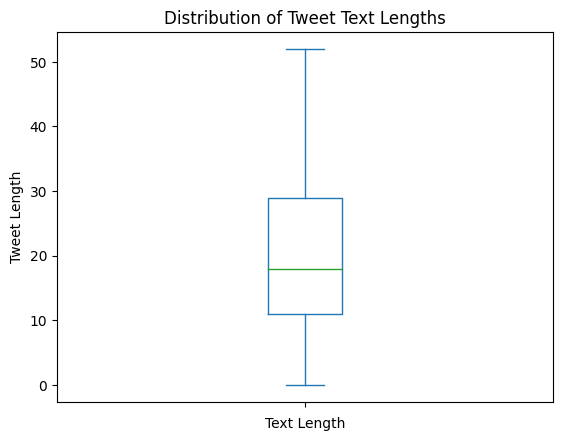

In [20]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')
plt.xlabel('Text Length')
plt.ylabel('Tweet Length')
plt.title('Distribution of Tweet Text Lengths')
plt.show()

###**Donut Plot**
***Distribution of Sentiment Labels***

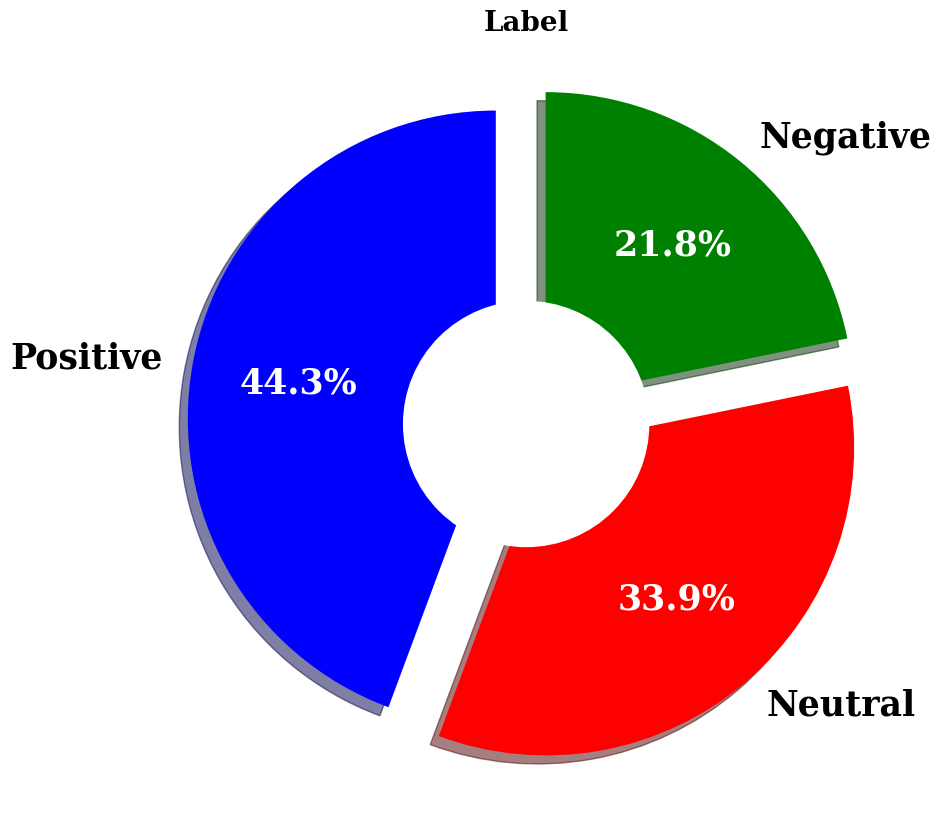

In [21]:
label_data = df['category'].value_counts()

explode = (0.1, 0.1, 0.1)
plt.figure(figsize=(14, 10))
patches, texts, pcts = plt.pie(label_data,
                               labels = label_data.index,
                               colors = ['blue', 'red', 'green'],
                               pctdistance = 0.65,
                               shadow = True,
                               startangle = 90,
                               explode = explode,
                               autopct = '%1.1f%%',
                               textprops={ 'fontsize': 25,
                                           'color': 'black',
                                           'weight': 'bold',
                                           'family': 'serif' }
                               )
plt.setp(pcts, color='white')

hfont = {'fontname':'serif', 'weight': 'bold'}
plt.title('Label', size=20, **hfont)

centre_circle = plt.Circle((0,0),0.40,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

###**Pie Plot**
***Distribution of Sentiments in Tweets***

In [22]:
counts = df['category'].value_counts()
fig = go.Figure(data=[go.Pie(labels=counts.index, values=counts)])
fig.update_layout(title ='Pie chart of different sentiments of tweets')
fig.show()

### **Histogram Plot**
***Distribution of Text Length for Positive Sentiment Tweets***

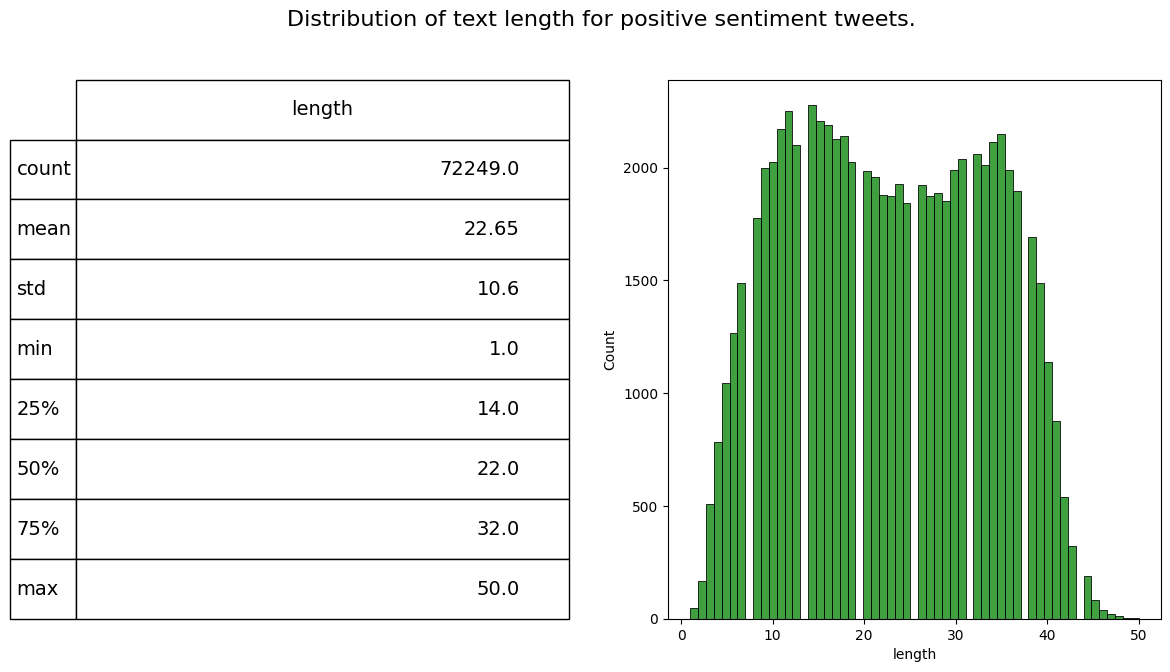

In [23]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

***Distribution of Text Length for Negative Sentiment Tweets***

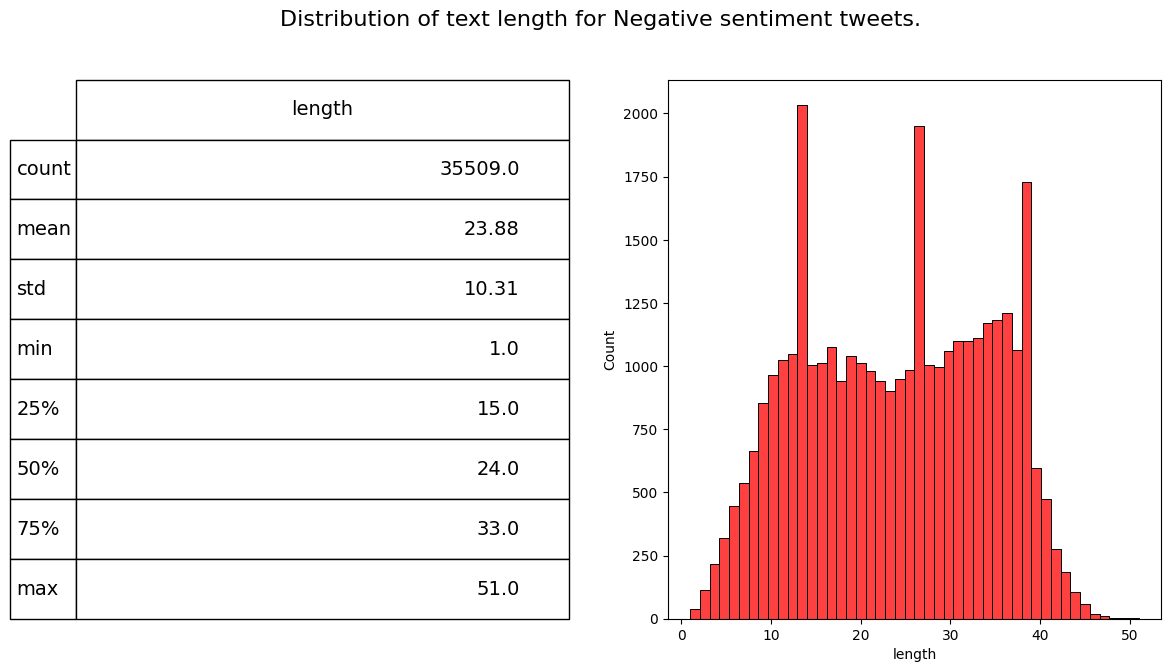

In [24]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment tweets.', fontsize=16)

plt.show()


In [25]:
df.drop(['length'], axis=1, inplace=True)
df.head

<bound method NDFrame.head of                                                clean_text  category
0       when modi promised “minimum government maximum...  Negative
1       talk all the nonsense and continue all the dra...   Neutral
2       what did just say vote for modi  welcome bjp t...  Positive
3       asking his supporters prefix chowkidar their n...  Positive
4       answer who among these the most powerful world...  Positive
...                                                   ...       ...
162975  why these 456 crores paid neerav modi not reco...  Negative
162976  dear rss terrorist payal gawar what about modi...  Negative
162977  did you cover her interaction forum where she ...   Neutral
162978  there big project came into india modi dream p...   Neutral
162979  have you ever listen about like gurukul where ...  Positive

[162969 rows x 2 columns]>

###**Sentiment Analysis Word Clouds**

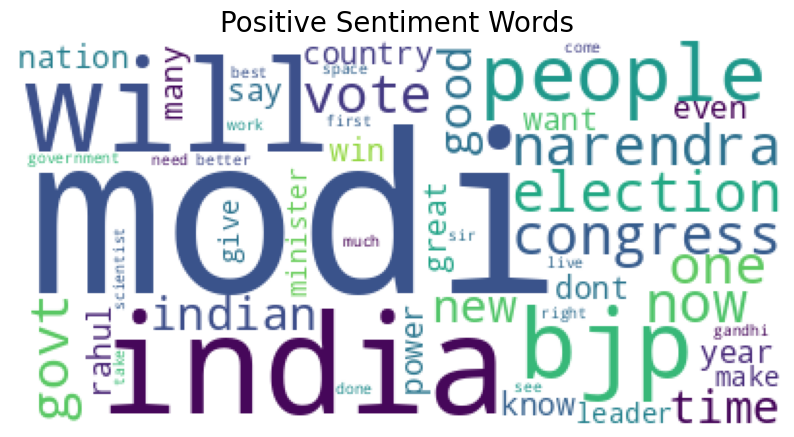

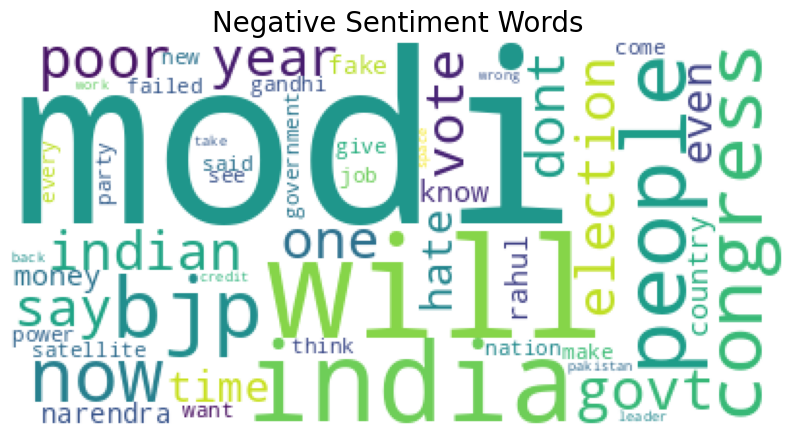

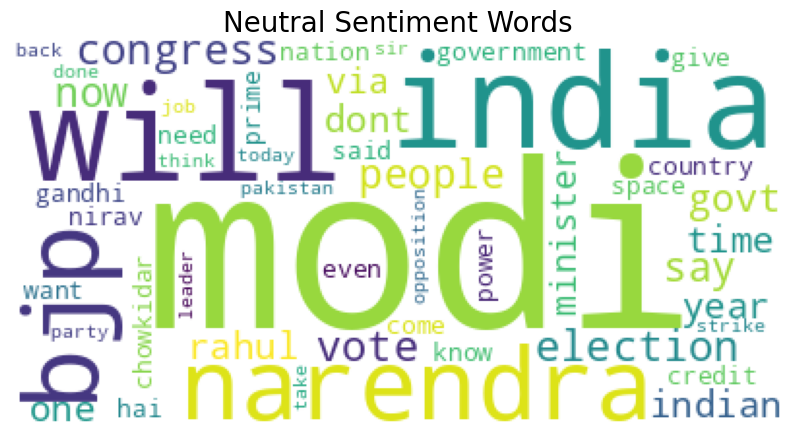

In [26]:
# generating the word cloud accordingly

def generate_wordcloud(df, category):
    tweets = df[df.category == category]['clean_text'].tolist()

    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in tweets])

    # Initialize wordcloud object
    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords=STOPWORDS,
                   collocations=False)

    # Generate and plot wordcloud
    plt.figure(figsize=(10, 10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()

# Positive tweet words
generate_wordcloud(df, 'Positive')

# Negative tweet words
generate_wordcloud(df, 'Negative')

# Neutral tweet words
generate_wordcloud(df, 'Neutral')

# **Data Preprocessing**

In [27]:
# Initialize the Porter Stemmer
stemmer = PorterStemmer()

# Initialize the RegexpTokenizer for word tokenization
tokenizer = RegexpTokenizer(r'\w+')

# Use a set for faster lookup of stopwords
stop_words = set(stopwords.words("english"))

def tweet_to_words(tweet):
    ''' Convert tweet text into a sequence of words '''

    # convert to lowercase, remove non-letters, tokenize, remove stopwords, and apply stemming
    words = [stemmer.stem(w) for w in tokenizer.tokenize(tweet.lower()) if w not in stop_words]

    return words

print("\nOriginal tweet ->", df['clean_text'][0])
print("\nProcessed tweet ->", tweet_to_words(df['clean_text'][0]))



Original tweet -> when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples

Processed tweet -> ['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']


In [28]:
# Apply data processing to each tweet
X = df['clean_text'].apply(tweet_to_words).tolist()
X

[['modi',
  'promis',
  'minimum',
  'govern',
  'maximum',
  'govern',
  'expect',
  'begin',
  'difficult',
  'job',
  'reform',
  'state',
  'take',
  'year',
  'get',
  'justic',
  'state',
  'busi',
  'exit',
  'psu',
  'templ'],
 ['talk', 'nonsens', 'continu', 'drama', 'vote', 'modi'],
 ['say',
  'vote',
  'modi',
  'welcom',
  'bjp',
  'told',
  'rahul',
  'main',
  'campaign',
  'modi',
  'think',
  'modi',
  'relax'],
 ['ask',
  'support',
  'prefix',
  'chowkidar',
  'name',
  'modi',
  'great',
  'servic',
  'confus',
  'read',
  'crustal',
  'clear',
  'crass',
  'filthi',
  'nonsens',
  'see',
  'abus',
  'come',
  'chowkidar'],
 ['answer',
  'among',
  'power',
  'world',
  'leader',
  'today',
  'trump',
  'putin',
  'modi',
  'may'],
 ['kiya', 'tho', 'refresh', 'maarkefir', 'comment', 'karo'],
 ['surat',
  'women',
  'perform',
  'yagna',
  'seek',
  'divin',
  'grace',
  'narendra',
  'modi',
  'becom'],
 ['come',
  'cabinet',
  'scholar',
  'like',
  'modi',
  'smriti

In [29]:
# Encode target labels
le = LabelEncoder()
Y = le.fit_transform(df['category'])
print(X[0])
print(Y[0])

['modi', 'promis', 'minimum', 'govern', 'maximum', 'govern', 'expect', 'begin', 'difficult', 'job', 'reform', 'state', 'take', 'year', 'get', 'justic', 'state', 'busi', 'exit', 'psu', 'templ']
0


##**Train and test split**

In [30]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

##**Bag of words (BOW) feature extraction**

In [31]:
vocabulary_size = 5000

# Tweets have already been preprocessed hence dummy function will be passed in to preprocessor & tokenizer step
count_vector = CountVectorizer(max_features=vocabulary_size,
                               preprocessor=lambda x: x,
                               tokenizer=lambda x: x)
# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()


In [32]:
feature_names = count_vector.get_feature_names_out()

# Print the first 200 words/tokens
print(feature_names[:200])

['100' '1000' '10000' '108' '10th' '111' '1145' '1200' '12000' '125' '12k'
 '130' '140' '14000' '150' '1500' '1500000' '1520' '157200000' '15l'
 '15lac' '15lakh' '160' '180' '1947' '1958' '1962' '1969' '1971' '1974'
 '1980' '1984' '1990' '1991' '1998' '1st' '200' '2000' '2002' '2004'
 '2007' '2008' '2009' '2010' '2011' '2012' '201213' '2013' '2014' '2015'
 '2016' '2017' '2018' '2019' '2020' '2022' '2024' '2025' '2029' '21st'
 '23rd' '247' '24x7' '250' '2611' '26th' '272' '27th' '280319' '282'
 '28th' '29th' '2cr' '2day' '2nd' '300' '3000' '30000' '300km' '31st'
 '350' '35a' '370' '3rd' '400' '4000' '456' '4th' '500' '5000' '50000'
 '5th' '5year' '5yr' '600' '6000' '60yr' '6th' '72000' '7200000' '72k'
 '7th' '800' '8020' '9000' 'aab' 'aadhaar' 'aadhar' 'aadmi' 'aag' 'aaj'
 'aalo' 'aam' 'aan' 'aap' 'aapk' 'aapko' 'aapn' 'aay' 'aaya' 'aayega'
 'aayog' 'abandon' 'abdul' 'abdullah' 'abe' 'abhi' 'abhinandan' 'abhisar'
 'abhiyan' 'abil' 'abki' 'abl' 'abolish' 'abp' 'abroad' 'abscond' 'absenc'

## **Plot the BoW feature vector**

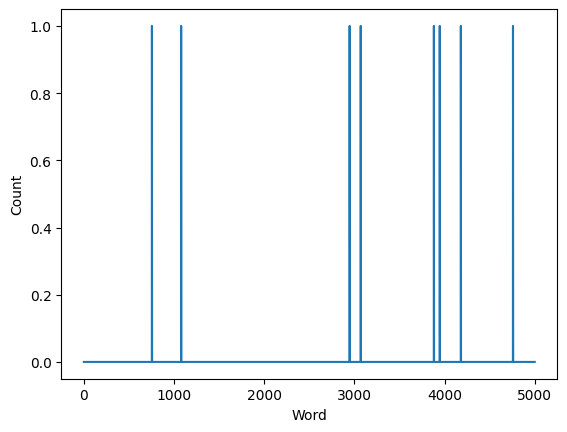

In [33]:
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

##**Tokenizing & Padding**

In [34]:
max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    # This function tokenize the input text into sequnences of intergers and then pad each sequence to the same length

    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  42    1  307   66 1726 1119   40 2378    2 1211  205    2  215   32
  155  100   49   69 1068  215   50    3    6  546    3   50 4179    3
 2806    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


##**Saving tokenized data**

In [35]:
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

##**Train & Test Split**

In [36]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (97781, 50) (97781, 3)
Validation Set -> (32594, 50) (32594, 3)
Test Set -> (32594, 50) (32594, 3)


In [37]:
def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

#**Bidirectional LSTM Using NN**

In [38]:
vocab_size = 5000
embedding_size = 32
epochs = 20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))


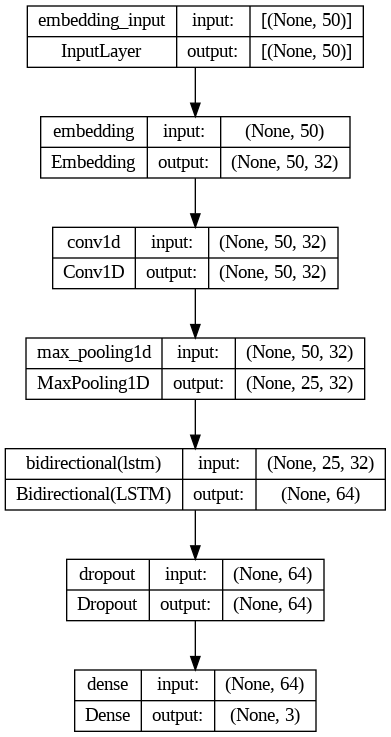

In [39]:
tf.keras.utils.plot_model(model, show_shapes=True)

## **Model Summary and Training Parameters**

In [40]:
print(model.summary())
# Use a larger batch size for faster training (adjust as per GPU memory)
batch_size = 256

# Use mixed precision training for faster computations and lower memory usage
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

# Use early stopping to stop training when validation loss increases
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Model checkpointing to save the best model during training with a unique filename
model_checkpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

# Compile model with Adam optimizer and a learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy', Precision(), Recall()])

# Create efficient data pipelines using tf.data API (example)
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Increase the number of epochs for more training
epochs = 30

# Train model with GPU acceleration, mixed precision, early stopping, and model checkpointing
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=epochs,
                    callbacks=[early_stopping, model_checkpoint], verbose=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 32)            160000    
                                                                 
 conv1d (Conv1D)             (None, 50, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 25, 32)           0         
 )                                                               
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 1

##**Model Accuracy & Loss**

In [41]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))
print('Loss      : {:.4f}'.format(loss))

Accuracy  : 0.9489
Precision : 0.9517
Recall    : 0.9455
F1 Score  : 0.9485
Loss      : 0.1923


###**Training History: Model Accuracy and Loss**

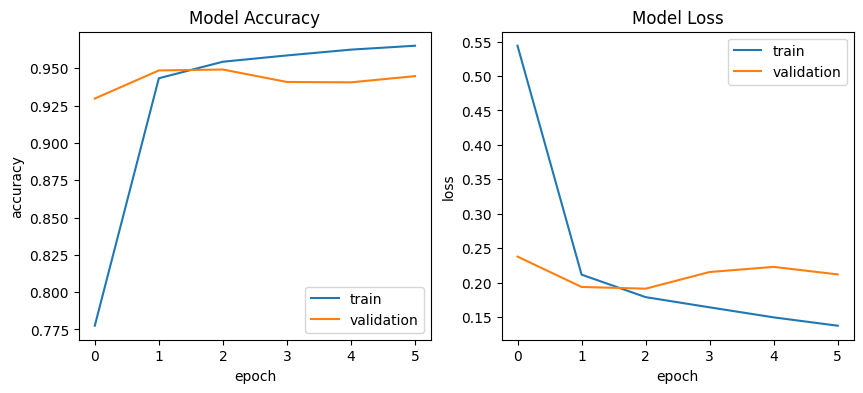

In [42]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

##**Model Confusion Matrix**

1019/1019 [==============================] - 5s 4ms/step


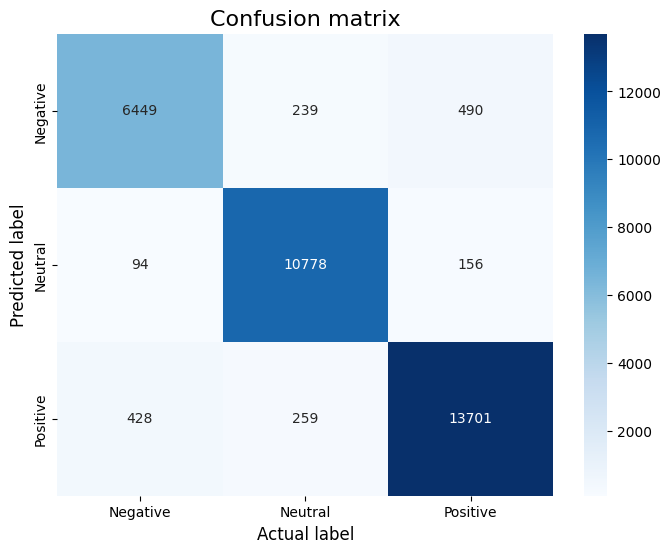

In [43]:
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)

##**Model save and load for the prediction**

In [44]:
model.save('best_model.h5')
print('Best model saved')

Best model saved


In [45]:
# Load model
model = load_model('best_model.h5')

def predict_class(text):
    '''Function to predict sentiment class of the passed text'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50

    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

# **predicting test sample**

In [46]:
predict_class(['I hate when I have to call and wake people up'])

1/1 [==============================] - 1s 697ms/step
The predicted sentiment is Negative


In [47]:
predict_class(['The food was meh'])

1/1 [==============================] - 0s 23ms/step
The predicted sentiment is Neutral


In [48]:
predict_class(['He is a best minister india ever had seen'])

1/1 [==============================] - 0s 25ms/step
The predicted sentiment is Positive


In [49]:
predict_class(['the food was not only the worst but also the customer service'])

1/1 [==============================] - 0s 22ms/step
The predicted sentiment is Negative


In [50]:
predict_class(['when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples'])

1/1 [==============================] - 0s 26ms/step
The predicted sentiment is Negative


In [51]:
predict_class(['I will be attending the conference tomorrow'])

1/1 [==============================] - 0s 23ms/step
The predicted sentiment is Neutral


In [52]:
predict_class(["Donald J. Trump's speech sounded eerily familiar... POTUS plans new deal for UK as Theresa May to be first foreign leader to meet new president since inauguration .@realdonaldtrump #Syria #Mexico #Russia & now #Afghanistan. Another #DearDonaldTrump Letter worth a read @AJEnglish"])

1/1 [==============================] - 0s 23ms/step
The predicted sentiment is Positive
